In [1]:
import requests
import PIL 
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing import image
from tensorflow.keras import layers


In [2]:
df = pd.read_csv('MTG_data.csv')#may need to change file name based on where the csv file is in your directory

In [3]:
def grab_image(img_path):
    i = np.asarray(PIL.Image.open(requests.get(img_path, stream=True).raw))
    i = np.expand_dims(i, axis = 0)
    return i

In [4]:
elm_num = len(df['File_Name']) #for full image set use len(df['File_Name'])

In [5]:
### Original code for offline access
directory = "C:/Users/16154/Documents/CSCI4850/MTG_data/"#access into to folder if the notebook is in the same directory as MTG_data

x = []#list to convert into an array
IMG_SIZE1 = 300 
IMG_SIZE2 = 300
for item in df['File_Name'][0:elm_num]:#delete index range to access the whole column
    img_array = cv2.imread(directory+item)
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    img_array = cv2.resize(img_array, (IMG_SIZE1, IMG_SIZE2))
    x.append(img_array)
X = np.asarray(x)

#printing a test image from the DF
#plt.imshow(X[0])#change index here to change image
#plt.show()


fileNames = 'http://73.88.178.142/img/' + df.File_Name
IMG_SIZE1 = 300
IMG_SIZE2 = 300

#path = Path(fileNames[0])
for fileName in fileNames:
    fileName = str(fileName)
    fileName = fileName.strip
    
PIC = np.concatenate([grab_image(fileNames[i]) for i in range(elm_num)])#for full image set use range(len(df['File_Name']))

X = []#A list to store resized image arrays 
for i in range(elm_num):#for full image set use range(len(df['File_Name']))
    temp = cv2.resize(PIC[i], (IMG_SIZE1, IMG_SIZE2))
    temp = cv2.cvtColor(temp, cv2.COLOR_RGBA2RGB)
    X.append(temp)
    

X = np.asarray(X)

X.shape

In [6]:
def list_2D(r, c):
    l = []
    for i in range(r):
        x = [0] * c
        l.append(x)
    return np.array(l)

In [7]:
#Convert labels from a list of names into one hot encodings
#Have the rest of the characters passed the length of the label to a 'null' one hot encoding
def labelsToOneHotEncodings_2(arr):    
    MAX_NUM_CHARS = 32 * 2 + 4 #Maxium number of characters a label can be
    SPECIAL_CHARS = 69 #Maxium number of special characters the one hot encoding will have
    count = 0
    
    #Array to contain each label's one hot encoding, 2-D arrays
    encodings = []
    
    #Convert each label into 2-D array to represent the one hot encoding
    for label in arr:
        count = count + 1
        i,j = -1,0 #Indexes for the postion to mark 1 into the 2-D array
        labelMat = list_2D(MAX_NUM_CHARS,SPECIAL_CHARS) #Special Characters by Max Number of Characters
        
        #Find the location to mark 1 into the one hot encoding that represents each character in the label
        for character in label:
        #Increase the position of the 2-D matrix to mark by each character in the label
            i+=1
                        
            #Check the character to determine the index of where to mark in the 2-D matrix
            if (((ord(character) - ord('a')) >= 0) and ((ord(character) - ord('a')) < 26)):#Lowercase Alphabet
                j = ord(character) - ord('a')
            elif (((ord(character) - ord('A')) >= 0) and ((ord(character) - ord('A')) < 26)):#Uppercase Alphabet
                j = 26 + (ord(character) - ord('A'))
            elif (((ord(character) - ord('0')) >= 0) and ((ord(character) - ord('0')) < 10)):#0-9
                j = 52 + (ord(character) - ord('0'))
            elif (ord(character) == 32):#' '
                j = 62
            elif (ord(character) == 44):#','
                j = 63
            elif (ord(character) == 45):#'-'
                j = 64
            elif (ord(character) == 39):#"'"
                j = 65
            elif (ord(character) == 47):#'/'
                j = 66
            elif (ord(character) == 64):#'@' null character
                j = 68
            else: #Garbage
                j = 67
            
            try:
                #Mark 1 into the position of the one hot encoding based on the indexes
                labelMat[i][j] = 1
            except:
                #Error Message for determing which label is causing issues for special character debugging
                print(label)
                print(len(label))
                print(count)
                break
                
                
        #Fill the rest of the missing characters of the label with the 'null' character one hot encodings
        for row in range(len(label),MAX_NUM_CHARS):
            labelMat[row][SPECIAL_CHARS-1] = 1
        
        #Add the one hot encoded matrix of the label into the list of labels' one hot encodings
        encodings.append(labelMat)
    
    #Return the encoded labels, the max number of characters, and the max number of special characters
    return np.array(encodings), MAX_NUM_CHARS, SPECIAL_CHARS

In [8]:
Y = []
for item in df['name'][0:elm_num]:#
    Y.append(item)

Y, row, col = labelsToOneHotEncodings_2(Y)

Our Market Research Shows That Players Like Really Long Card Names So We Made this Card to Have the Absolute Longest Card Name Ever Elemental
141
10773


In [9]:
def oneHotEncodingToWord(encoding):
    #String to capture the word decoded from the one hot encodings
    word = ""
    
    #Decode each character in the onehot encoding and add the character to the word
    for i in range(len(encoding)):
        #Find the index that is the character represented by the one hot encoding
        #j = linearsearch(encoding[i],1)
        j = np.argmax(encoding[i],-1)
        
        #Decode the index to represent a special character
        #Then apply the character to the end of the word
        if (j == 68 or j == 67): #Null or garbage characters
            break
        elif (j >= 0 and j < 26): #Lowercase Aplhabet
            word = word + chr(97 + j)
        elif (j >= 26 and j < 52): #Uppercase Aplhabet
            j = j - 26
            word = word + chr(65 + j)
        elif (j >= 52 and j < 62): #Digits (0-9)
            j = j - 52
            word = word + chr(48 + j)
        elif (j == 62): #Space character
            word = word + " "
        elif (j == 63): #Comma character
            word = word + ','
        elif (j == 64): #Dash character
            word = word + '-'
        elif (j == 65): #Hyphen charcter
            word = word + "'"
        elif (j == 66): #Foward slash character
            word = word + '/'

    return word

In [10]:
oneHotEncodingToWord(Y[9])

'Wall of Roots'

In [13]:
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

data_generator = keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.0,
    height_shift_range=0.0,
    rotation_range=0,
    zoom_range=0.0,
    horizontal_flip=False)
split_point = int(0.8*elm_num)
dg_trainer = data_generator.flow(X[:split_point],
                                 Y[:split_point],
                                 batch_size=32)

In [14]:
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
values = initializer(shape=(300, 300))

x = keras.layers.Input(X.shape[1:])#Keep this
y = x#Keep this
y = keras.layers.Conv2D(64, kernel_size=(8,8), activation='relu')(y)
y = keras.layers.MaxPooling2D(pool_size=(4,4))(y)
y = keras.layers.Dropout(0.2)(y)
y = keras.layers.Conv2D(128, kernel_size=(8,8), activation='relu')(y)
y = keras.layers.MaxPooling2D(pool_size=(4,4))(y)
y = keras.layers.Dropout(0.2)(y)
y = keras.layers.Flatten()(y)
y = keras.layers.Dense(4692)(y)#Keep this
y = keras.layers.Reshape((68,69))(y)#Keep this

y = keras.layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(y)
y = keras.layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(y)

y = keras.layers.Flatten()(y)
y = keras.layers.Dense(4692)(y)#Keep this
y = keras.layers.Reshape((68,69))(y)#Keep this

model = keras.Model(x,y)
model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.CategoricalAccuracy()])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 293, 293, 64)      12352     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 73, 73, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 66, 66, 128)       524416    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                         

In [ ]:
keras.utils.plot_model(model,show_shapes=True,expand_nested=True)

In [15]:
epochs = 5
history = model.fit(dg_trainer,
                    epochs=epochs,
                    verbose=1,
                    validation_data = (X[split_point:],Y[split_point:]))

Epoch 1/5
757/757 [==============================] - 4761s 6s/step - loss: 13.8995 - categorical_accuracy: 0.4444 - val_loss: 14.0089 - val_categorical_accuracy: 0.4593
Epoch 2/5
757/757 [==============================] - 3731s 5s/step - loss: 13.6986 - categorical_accuracy: 0.4567 - val_loss: 13.9213 - val_categorical_accuracy: 0.4593
Epoch 3/5
757/757 [==============================] - 3834s 5s/step - loss: 13.6676 - categorical_accuracy: 0.4608 - val_loss: 13.3310 - val_categorical_accuracy: 0.4593
Epoch 4/5
757/757 [==============================] - 3768s 5s/step - loss: 13.6348 - categorical_accuracy: 0.4487 - val_loss: 13.9102 - val_categorical_accuracy: 0.4455
Epoch 5/5
757/757 [==============================] - 3805s 5s/step - loss: 13.5819 - categorical_accuracy: 0.4406 - val_loss: 13.8546 - val_categorical_accuracy: 0.4466


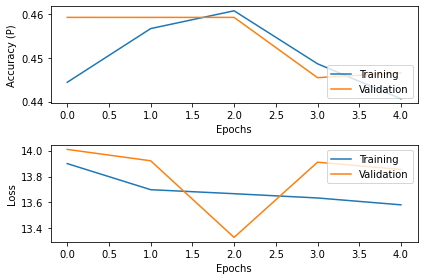

In [16]:
plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Accuracy (P)')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='lower right')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show() 


## Reference code

### Oringinal Code for accessing the files online

fileNames = 'http://73.88.178.142/img/' + df.File_Name
IMG_SIZE1 = 300
IMG_SIZE2 = 300

#path = Path(fileNames[0])
for fileName in fileNames:
    fileName = str(fileName)
    fileName = fileName.strip

#pics = []
#for i in range(10):
    #I = np.asarray(PIL.Image.open(requests.get(fileNames[i], stream=True).raw))
    #pics.append(I)


PIC = np.concatenate([grab_image(fileNames[i]) for i in range(10)])#for full image set use range(len(df['File_Name']))
#print(I.shape)
#im = Image.open(requests.get(fileNames[0], stream=True).raw)

#path.name
#print(fileNames[0])
#type(fileNames[0])
#pic = np.concatenate(grab_image(requests.get(fileNames[0], stream=True).raw))
#print(pics[0].shape)
for i in range(10):
    plt.imshow(image.array_to_img(PIC[i]))
    plt.show()

### Onehot Encoder 1st gen

#Convert labels from a list of names into one hot encodings
#Have one null character for the full one hot encoding of the label
def labelsToOneHotEncodings(arr):
    #Add 'null' special character to each label
    arr = [each_string + "@" for each_string in arr]
    
    MAX_NUM_CHARS = 32 #Maxium number of characters a label can be
    SPECIAL_CHARS = 69 #Maxium number of special characters the one hot encoding will have
    
    #Array to contain each label's one hot encoding, 2-D arrays
    encodings = []
    
    #Convert each label into 2-D array to represent the one hot encoding
    for label in arr:
        i,j = -1,0 #Indexes for the postion to mark 1 into the 2-D array
        labelMat = list_2D(MAX_NUM_CHARS,SPECIAL_CHARS) #Special Characters by Max Number of Characters
        
        #Find the location to mark 1 into the one hot encoding that represents each character in the label
        for character in label:
            #Increase the position of the 2-D matrix to mark by each character in the label
            i+=1
                        
            #Check the character to determine the index of where to mark in the 2-D matrix
            if (((ord(character) - ord('a')) >= 0) and ((ord(character) - ord('a')) < 26)):#Lowercase Alphabet
                j = ord(character) - ord('a')
            elif (((ord(character) - ord('A')) >= 0) and ((ord(character) - ord('A')) < 26)):#Uppercase Alphabet
                j = 26 + (ord(character) - ord('A'))
            elif (((ord(character) - ord('0')) >= 0) and ((ord(character) - ord('0')) < 10)):#0-9
                j = 52 + (ord(character) - ord('0'))
            elif (ord(character) == 32):#' '
                j = 62
            elif (ord(character) == 44):#','
                j = 63
            elif (ord(character) == 45):#'-'
                j = 64
            elif (ord(character) == 39):#"'"
                j = 65
            elif (ord(character) == 47):#'/'
                j = 66
            elif (ord(character) == 64):#'@'
                j = 68
            else: #Garbage
                j = 67
            
            #Mark 1 into the position of the one hot encoding based on the indexes
            try:
                labelMat[i][j] = 1
            except:
                #Error Message for determing the value of this index for special character debugging
                print(j)
        
        #Add the one hot encoded matrix of the label into the list of labels' one hot encodings
        encodings.append(labelMat)
        
    #Return the encoded labels, the max number of characters, and the max number of special characters
    return np.array(encodings), MAX_NUM_CHARS, SPECIAL_CHARS